# Constant Velocity Model (Baseline)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset

In [2]:
import torch.utils
import torch.utils.data


lookback = 30
future_steps = 40
dir = '../data/PandasData/Sampled/'
ds = MyDataset(lookback=lookback)
train_batch_size = 16
test_batch_size = 16
FRAME_RATE = 10

def process_data(df_dir : str, target_freq : int = FRAME_RATE):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.dropna(inplace=True, how='any')
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    if f_per_sec < target_freq:
        raise ValueError('The frequency of the data is lower than the target frequency')
    elif int(f_per_sec) == target_freq:
        pass
    else:
        resample_ratio = int(f_per_sec/target_freq)
        df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget']:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)


In [4]:
ds.generate_data(future_steps=future_steps)

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)


feature_dim = ds.feature_dim
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'start_station_X', 'start_station_Y', 'end_station_X',
       'end_station_Y', 'distance_from_start_station_X',
       'distance_from_start_station_Y', 'distance_from_end_station_X',
       'distance_from_end_station_Y', 'facing_start_station',
       'facing_end_station', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'AGV_name',
       'looking_at_closest_station', 'rolling_avg'],
      dtype='object') 
feature_dim : 32


In [5]:
import torch
import torch.nn as nn

class ConstantVelocityModel(nn.Module):
    def __init__(self, frame_rate : int = 10):
        super(ConstantVelocityModel, self).__init__()
        self.FRAME_RATE = frame_rate

    def forward(self, x, n_past_frames = 30, n_future_frames = 20):
        # Calculate the mean velocity
        # x shape: [batch_size, n_frames, n_features]
        # Using the first two features which are X and Y positions
        velocities = (x[:, 1:n_past_frames, :2] - x[:, :n_past_frames-1, :2]) * self.FRAME_RATE  # Multiply by frame rate to get velocity
        mean_velocity = torch.mean(velocities, dim=1, keepdim=True)

        # Predict future positions
        initial_positions = x[:, n_past_frames-1, :2].unsqueeze(1)
        time_steps = torch.arange(1, n_future_frames+1, device=x.device).view(1, -1, 1)
        predictions = initial_positions + mean_velocity * time_steps / self.FRAME_RATE  # Divide by frame rate

        return predictions
    
model = ConstantVelocityModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cuda


In [6]:
n_past_frames = 30
validation_step = future_steps
predictions = []
truths = []


with torch.no_grad():
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        y_pred = model(X_test_batch, n_past_frames = n_past_frames, n_future_frames = validation_step)
        predictions.append(y_pred[:, :validation_step, :2])
        truths.append(y_test_batch[:, :validation_step, :2])
        
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

  0%|          | 0/459 [00:00<?, ?it/s]

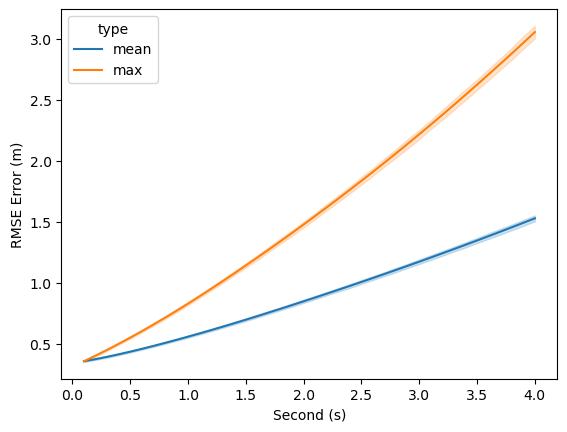

In [8]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, future_steps+1):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type')
plt.savefig('../figure/constant_velocity_model.png')
plt.show()